In [1]:
import sionna as sn
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

2023-06-13 14:34:14.318993: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-13 14:34:14.320595: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-13 14:34:14.356018: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-13 14:34:14.356668: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 14:34:14.946362: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
BATCH_SIZE = 1000
NUM_BITS_PER_SYMBOL = 4
CODERATE = 0.5
NUM_CODED_BITS = 1000
NUM_INFO_BITS = int(NUM_CODED_BITS * CODERATE)

In [3]:
class AWGNModel(tf.keras.Model):
    
    def __init__(self, coding_type=False):
        super().__init__()

        self.coding_type = coding_type

        self.binary_source = sn.utils.BinarySource()

        constellation = sn.mapping.Constellation('qam', NUM_BITS_PER_SYMBOL)

        self.mapper = sn.mapping.Mapper(constellation=constellation)
        self.demapper = sn.mapping.Demapper('app', constellation=constellation)

        self.ldpc_encoder = sn.fec.ldpc.LDPC5GEncoder(NUM_INFO_BITS, NUM_CODED_BITS)
        self.ldpc_decoder = sn.fec.ldpc.LDPC5GDecoder(encoder=self.ldpc_encoder, hard_out=True)

        self.polar_encoder = sn.fec.polar.Polar5GEncoder(NUM_INFO_BITS, NUM_CODED_BITS)
        self.polar_decoder = sn.fec.polar.Polar5GDecoder(self.polar_encoder, dec_type='SC')

        self.channel = sn.channel.AWGN()
    
    @tf.function
    def __call__(self, batch_size, ebno_db):

        no = sn.utils.ebnodb2no(
            coderate=CODERATE,
            ebno_db=ebno_db,
            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
        )

        bits = self.binary_source([batch_size, NUM_INFO_BITS])

        if self.coding_type == 'ldpc':
            coded_bits = self.ldpc_encoder(bits)
        elif self.coding_type == 'polar':
            coded_bits = self.polar_encoder(bits)
        else:
            coded_bits = bits

        symbols = self.mapper(coded_bits)

        received_symbols = self.channel([symbols, no])

        llr = self.demapper([received_symbols, no])

        if self.coding_type == 'ldpc':
            bits_hat = self.ldpc_decoder(llr)
        elif self.coding_type == 'polar':
            bits_hat = self.polar_decoder(llr)
        else:
            bits_hat = llr


        return bits, bits_hat

In [4]:
ber_plots = sn.utils.PlotBER('Canal AWGN')
EBNO_DBS = np.linspace(-5,10,16)

In [5]:
no_coding_model = AWGNModel()

ber_plots.simulate(
    no_coding_model,
    batch_size=BATCH_SIZE,
    ebno_dbs=EBNO_DBS,
    num_target_bit_errors=1000,
    legend='Sem codificação',
    soft_estimates=True,
    max_mc_iter=100,
    show_fig=False
);

2023-06-13 14:34:16.225717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'batch_size' with dtype int32
	 [[{{node batch_size}}]]


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.2646e-01 | 1.0000e+00 |      163230 |      500000 |         1000 |        1000 |         0.8 |reached target bit errors
     -4.0 | 3.0509e-01 | 1.0000e+00 |      152545 |      500000 |         1000 |        1000 |         0.0 |reached target bit errors
     -3.0 | 2.8237e-01 | 1.0000e+00 |      141184 |      500000 |         1000 |        1000 |         0.0 |reached target bit errors
     -2.0 | 2.5860e-01 | 1.0000e+00 |      129298 |      500000 |         1000 |        1000 |         0.0 |reached target bit errors
     -1.0 | 2.3450e-01 | 1.0000e+00 |      117250 |      500000 |         1000 |        1000 |         0.0 |reached target bit errors
      0.0 | 2.1084e-01 | 1.0000e+00 |      105421 |      500000 |         1

In [6]:
ldpc_coding_model = AWGNModel('ldpc')

ber_plots.simulate(
    ldpc_coding_model,
    batch_size=BATCH_SIZE,
    ebno_dbs=EBNO_DBS,
    num_target_bit_errors=1000,
    legend='LDPC',
    soft_estimates=True,
    max_mc_iter=100,
    show_fig=False
);

2023-06-13 14:34:17.513611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'batch_size' with dtype int32
	 [[{{node batch_size}}]]


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.6637e-01 | 1.0000e+00 |      183184 |      500000 |         1000 |        1000 |         3.0 |reached target bit errors
     -4.0 | 3.4906e-01 | 1.0000e+00 |      174528 |      500000 |         1000 |        1000 |         1.4 |reached target bit errors
     -3.0 | 3.2868e-01 | 1.0000e+00 |      164340 |      500000 |         1000 |        1000 |         1.4 |reached target bit errors
     -2.0 | 3.0803e-01 | 1.0000e+00 |      154013 |      500000 |         1000 |        1000 |         1.4 |reached target bit errors
     -1.0 | 2.8315e-01 | 1.0000e+00 |      141577 |      500000 |         1000 |        1000 |         1.4 |reached target bit errors
      0.0 | 2.5438e-01 | 1.0000e+00 |      127192 |      500000 |         1

In [7]:
polar_coding_model = AWGNModel('polar')

ber_plots.simulate(
    polar_coding_model,
    batch_size=BATCH_SIZE,
    ebno_dbs=EBNO_DBS,
    num_target_bit_errors=1000,
    legend='Polar',
    soft_estimates=True,
    max_mc_iter=100,
    show_fig=False
);

2023-06-13 14:38:57.489210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'batch_size' with dtype int32
	 [[{{node batch_size}}]]


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 4.9558e-01 | 1.0000e+00 |      247792 |      500000 |         1000 |        1000 |        47.3 |reached target bit errors
     -4.0 | 4.9522e-01 | 1.0000e+00 |      247609 |      500000 |         1000 |        1000 |         0.2 |reached target bit errors
     -3.0 | 4.9275e-01 | 1.0000e+00 |      246375 |      500000 |         1000 |        1000 |         0.2 |reached target bit errors
     -2.0 | 4.9063e-01 | 1.0000e+00 |      245313 |      500000 |         1000 |        1000 |         0.2 |reached target bit errors
     -1.0 | 4.8884e-01 | 1.0000e+00 |      244418 |      500000 |         1000 |        1000 |         0.2 |reached target bit errors
      0.0 | 4.8611e-01 | 1.0000e+00 |      243053 |      500000 |         1

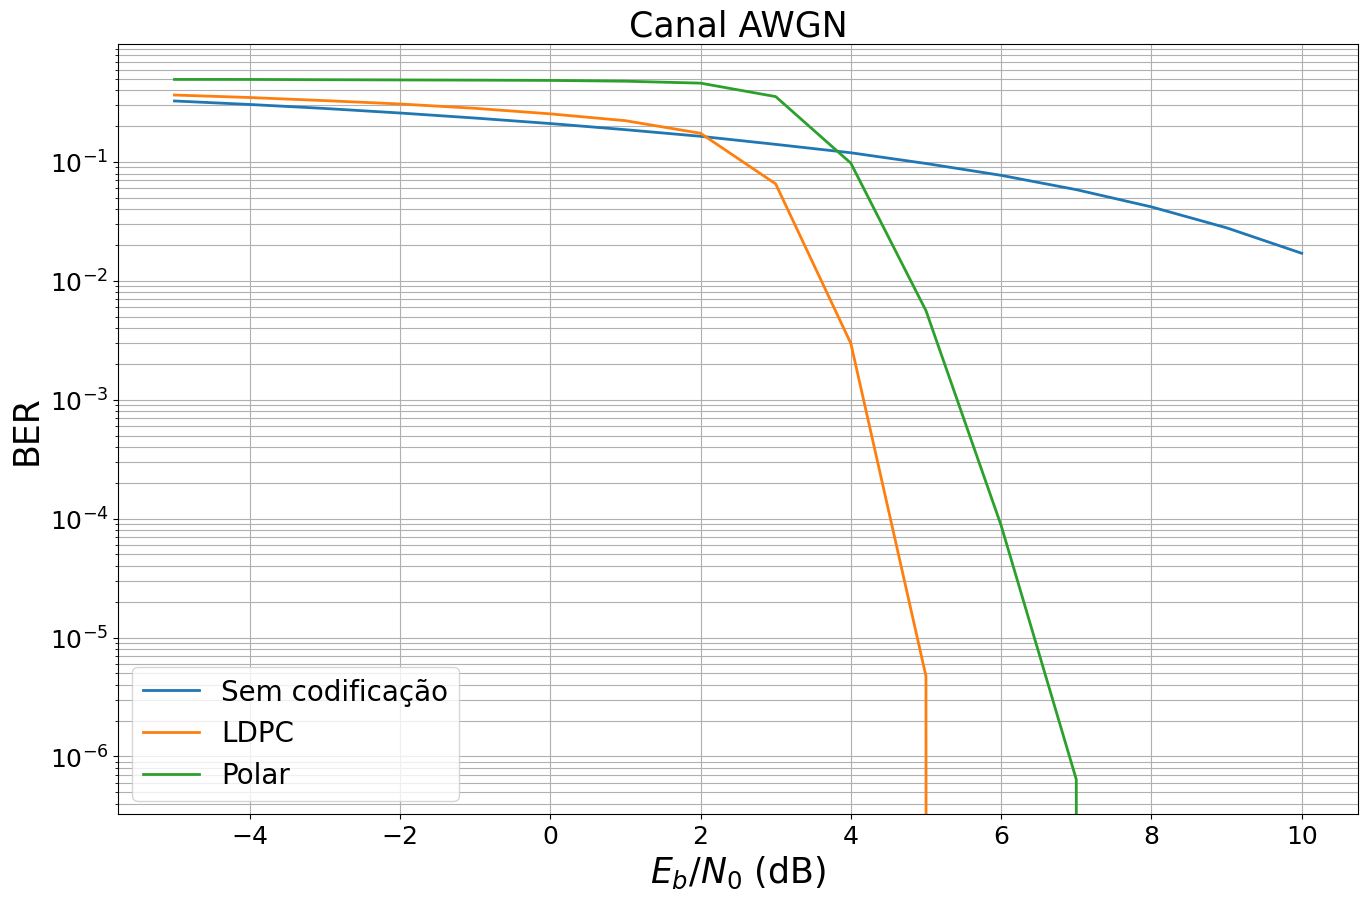

In [8]:
ber_plots()